# **Logistic Regression: Sentiment analysis**

In [3]:
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

import matplotlib.pyplot as plt

## Load Dataset

In [4]:
df = pd.read_csv("data/sentiment_analysis.csv", index_col="id")
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7920 entries, 1 to 7920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7920 non-null   int64 
 1   tweet   7920 non-null   object
dtypes: int64(1), object(1)
memory usage: 185.6+ KB


## Preprocessing

In [ ]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r"RT[\s]+", "", text)
    
    # Hyperlinks removal
    text = re.sub(r"https?:\/\/.*[\r\n]*", "", text)
    
    # Hashtags removal
    text = re.sub(r"#", "", text)
    
    # Punctuation removal
    text = re.sub(r"[^\w\s]", "", text)
    
    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)
    return text_tokens

In [22]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        tweet = row["tweet"]
        label = row["label"]
    
        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
    return freqs

In [26]:
def get_feature(test, freqs):
    tokens = text_normalize(test)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X 

In [27]:
X, y = [], []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row["tweet"]
    label = row["label"]
    
    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

## Train Test Val Split 7:2:1

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2, shuffle=True
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6336, 3), (1584, 3), (6336,), (1584,))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.125, random_state=2, shuffle=True
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5544, 3), (792, 3), (5544,), (792,))

## Normalization

In [34]:
normalizer = StandardScaler()

X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

## Train & Evaluation

In [35]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict(X, theta):
    return sigmoid(np.dot(X, theta))


def compute_loss(y, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()


def compute_gradient(X, y, y_pred):
    return np.dot(X.T, (y_pred - y)) / y.size


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_pred = predict(X, theta).round()
    acc = (y_pred == y).mean()
    return acc

In [36]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(2)
theta = np.random.uniform(
    size=X_train.shape[1]
)

In [37]:
train_accs, train_losses = [], []
val_accs, val_losses = [], []

for epoch in range (epochs):
    train_batch_losses, train_batch_accs = [], []
    val_batch_losses, val_batch_accs = [], []

    for i in range (0, X_train.shape[0], batch_size):
        X_i = X_train[i : i+batch_size]
        y_i = y_train[i : i+batch_size]

        y_pred = predict(X_i, theta)
        train_loss = compute_loss(y_i, y_pred)
        train_batch_losses.append(train_loss)
        gradient = compute_gradient(X_i, y_i, y_pred)
        theta = update_theta(theta, gradient, lr)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_pred = predict(X_val, theta)
        val_loss = compute_loss(y_val, y_val_pred)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
    
    train_batch_loss = np.mean(train_batch_losses)
    val_batch_loss = np.mean(val_batch_losses)
    train_batch_acc = np.mean(train_batch_accs)
    val_batch_acc = np.mean(val_batch_accs)

    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)

    print(f"\nEPOCH {epoch + 1}: \tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}")



EPOCH 1: 	Training loss: 0.707	Validation loss: 0.704

EPOCH 2: 	Training loss: 0.661	Validation loss: 0.659

EPOCH 3: 	Training loss: 0.624	Validation loss: 0.622

EPOCH 4: 	Training loss: 0.593	Validation loss: 0.591

EPOCH 5: 	Training loss: 0.569	Validation loss: 0.566

EPOCH 6: 	Training loss: 0.548	Validation loss: 0.546

EPOCH 7: 	Training loss: 0.531	Validation loss: 0.529

EPOCH 8: 	Training loss: 0.516	Validation loss: 0.514

EPOCH 9: 	Training loss: 0.504	Validation loss: 0.502

EPOCH 10: 	Training loss: 0.494	Validation loss: 0.491

EPOCH 11: 	Training loss: 0.485	Validation loss: 0.483

EPOCH 12: 	Training loss: 0.477	Validation loss: 0.475

EPOCH 13: 	Training loss: 0.471	Validation loss: 0.468

EPOCH 14: 	Training loss: 0.465	Validation loss: 0.463

EPOCH 15: 	Training loss: 0.460	Validation loss: 0.457

EPOCH 16: 	Training loss: 0.456	Validation loss: 0.453

EPOCH 17: 	Training loss: 0.452	Validation loss: 0.449

EPOCH 18: 	Training loss: 0.448	Validation loss: 0.445



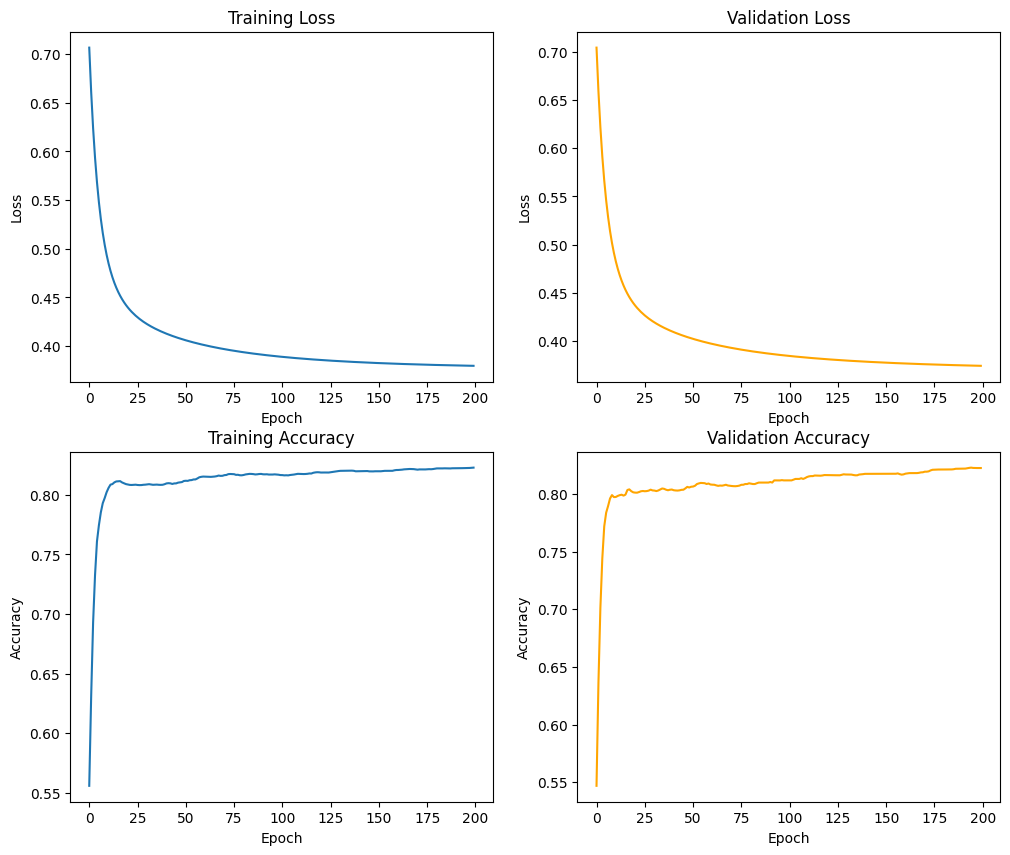

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()

In [39]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print("Evaluation on validation test set: ")
print("Validation Accuracy: ", val_set_acc)
print("Test Accuracy: ", test_set_acc)

Evaluation on validation test set: 
Validation Accuracy:  0.82260101010101
Test Accuracy:  0.8434343434343434
